In [2]:
''' DEDlib is a Distributional Exact Diagonalization tooling library for study of Anderson (multi-)impurity model in Graphene Nanoribbons'''

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.auto import trange
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy
from numba import njit

class DEDlib:
    def __init__(self,**kwargs):
        self.Nit,self.poles,self.Uimp,self.Sigma,self.Ed,self.Gamma,self.SizeO,self.etaco,self.ctype,self.Edcalc,self.bound,self.Tk,self.Nimpurities,self.U2imp,self.Jimp,self.posb=200000,4,3,3/2,-3/2,0.3,1001,[0.02,1e-39],'n','',3,[0],1,0,0,1
        #for arg in args: setattr(self, [name for name, value in globals().items() if value is arg][0], arg)
        #print(kwargs[0])
        for kwarg,val in kwargs.items(): setattr(self,kwarg,val)
        self.omega,self.eta,self.selectpcT,self.selectpT,self.Npoles=np.linspace(-self.bound,self.bound,self.SizeO),self.etaco[0]*abs(np.linspace(-self.bound,self.bound,self.SizeO))+self.etaco[1],[],[],int(self.poles/self.Nimpurities)
        self.c,self.pbar=[self.Jordan_wigner_transform(i,2*self.poles) for i in range(2*self.poles)],trange(self.Nit,position=self.posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
        (self.Hn,self.n)=self.Operators(self.c,self.Nimpurities,self.poles)
        self.ndfin,self.NewSigma,self.fDOS,self.Lor,self.tsim=self.main()

    def Jordan_wigner_transform(self,j,lattice_length):
        """Jordan_wigner_transform(j, lattice_length). 
    Defines the Jordan Wigner transformation for a 1D lattice."""
        operators=sigmaz()
        for _ in range(j-1): operators=tensor(operators,sigmaz())
        if j == 0: operators=sigmam()
        else: operators=tensor(operators,sigmam())
        for _ in range(lattice_length - j - 1): operators=tensor(operators,identity(2))
        return operators
    
    def Operators(self,c,Nimpurities,poles):
        posimp=[int(2*poles/Nimpurities*i) for i in range(Nimpurities)]
        impn=[sum([c[posimp[k]+i].dag()*c[posimp[k]+i] for i in range(2)]) for k in range(Nimpurities)]
        bathn=[[sum([c[2*j+i+2+posimp[k]].dag()*c[2*j+i+2+posimp[k]] for i in range(2)]) for j in range(int(poles/Nimpurities)-1)] for k in range(Nimpurities)]
        crossn=[[sum([c[posimp[k]+i].dag()*c[2*j+i+2+posimp[k]]+c[2*j+i+2+posimp[k]].dag()*c[posimp[k]+i] for i in range(2)]) for j in range(int(poles/Nimpurities)-1)] for k in range(Nimpurities)]
        Un=sum([c[posimp[k]].dag()*c[posimp[k]]*c[posimp[k]+1].dag()*c[posimp[k]+1] for k in range(Nimpurities)])
        Sigman=sum([c[posimp[k]].dag()*c[posimp[k]]+c[posimp[k]+1].dag()*c[posimp[k]+1] for k in range(Nimpurities)])
        U2n=sum([c[posimp[k]+i].dag()*c[posimp[k]+i]*c[posimp[l]+j].dag()*c[posimp[l]+j] for i in range(2) for j in range(2) for l in range(Nimpurities) for k in range(Nimpurities) if k !=l])
        Jn=sum([1/2*(c[posimp[k]].dag()*c[posimp[k]+1]*c[posimp[l]+1].dag()*c[posimp[l]]+c[posimp[k]+1].dag()*c[posimp[k]]*c[posimp[l]].dag()*c[posimp[l]+1])
                        +1/4*(c[posimp[k]].dag()*c[posimp[k]]-c[posimp[k]+1].dag()*c[posimp[k]+1])*(c[posimp[l]].dag()*c[posimp[l]]-c[posimp[l]+1].dag()*c[posimp[l]+1]) for l in range(Nimpurities) for k in range(Nimpurities) if k!=l])
        n=[sum([c[j+posimp[i]].dag()*c[j+posimp[i]] for j in range(2*int(poles/Nimpurities))]) for i in range(Nimpurities)]
        return (impn,bathn,crossn,Un,Sigman,U2n,Jn),n

    def main(self):
        AvgSigmadat,Nfin,nd=np.zeros((len(self.Tk),self.SizeO),dtype='complex_'),np.zeros(len(self.Tk),dtype='float'),np.zeros(len(self.Tk),dtype='complex_')
        while self.pbar.n<self.Nit:
            reset=False
            while not reset:
                NewM,nonG,select=self.Startrans(self.Npoles,np.sort(self.Lorentzian(self.omega,self.Gamma,self.Npoles,self.Ed,self.Sigma)[1]),self.omega,self.eta)
                H0,H=self.HamiltonianAIM(np.repeat(NewM[0][0],self.Nimpurities),np.tile([NewM[k+1][k+1] for k in range(len(NewM)-1)],(self.Nimpurities,1)),np.tile(NewM[0,1:],(self.Nimpurities,1)),self.Uimp,self.Sigma,self.U2imp,self.Jimp,self.Hn)
                try: (MBGdat,Boltzmann,Ev0),reset=self.Constraint(self.ctype,H0,H,self.omega,self.eta,self.c,self.n,self.Tk,np.array([ar<self.Nit for ar in Nfin]))
                except (np.linalg.LinAlgError,ValueError,scipy.sparse.linalg.ArpackNoConvergence): (MBGdat,Boltzmann,Ev0),reset=(np.zeros(len(self.omega),dtype='complex_'),np.zeros(len(self.Tk)),np.array([])),False
                if np.isnan(1/nonG-1/MBGdat+self.Sigma).any() or np.array([i>=1000 for i in np.real(1/nonG-1/MBGdat+self.Sigma)]).any(): reset=False
                self.selectpT.append(select)
            Nfin,AvgSigmadat,nd=Nfin+Boltzmann,AvgSigmadat+(1/nonG-1/MBGdat+self.Sigma)*Boltzmann[:,None],nd+np.conj(Ev0).T@sum(self.Hn[0]).data.tocoo()@Ev0*Boltzmann
            self.selectpcT.append(select)
            if self.ctype=='sn': self.pbar.n+=1
            else: self.pbar.n=int(min(Nfin))
            self.pbar.refresh()
        self.pbar.close()
        if self.Edcalc == 'AS': return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(self.omega-AvgSigmadat/Nfin[:,None]+(AvgSigmadat[:,int(np.round(self.SizeO/2))]/Nfin)[:,None]+1j*self.Gamma)))/np.pi).squeeze(),self.Lorentzian(self.omega,self.Gamma,self.poles)[0],self.pbar.format_dict["elapsed"]
        else: return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(self.omega-AvgSigmadat/Nfin[:,None]-self.Ed+1j*self.Gamma)))/np.pi).squeeze(),self.Lorentzian(self.omega,self.Gamma,self.poles,self.Ed,self.Sigma)[0],self.pbar.format_dict["elapsed"]

    #@njit
    def Lorentzian(self,omega,Gamma,poles,Ed=-3/2,Sigma=3/2):
        """Lorentzian(omega, Gamma, poles,Ed=-3/2,Sigma=3/2). 
    Defines the non-interacting DOS (rho0) and selects random sites based on the number of sites in the 1D lattice model and the calculated distribution."""
        return -np.imag(1/(omega-Ed-Sigma+1j*Gamma))/np.pi,np.array([Gamma*np.tan(np.pi*(pi-1/2))+Ed+Sigma for pi in np.random.uniform(0,1,poles)])

    #@njit
    def Startrans(self,poles,select,omega,eta,row=0):
        """Startrans(poles,select,row,omega, eta). 
    Function to transform 1D lattice matrices in order to calculates parameters impengergy, bathenergy and Vkk from random sampling distribution."""
        Pbath,Dbath,pbar,G=np.zeros((poles,poles)),np.zeros((poles,poles)),np.zeros((poles,poles)),np.zeros(omega.shape,dtype='complex_')
        for i in range(poles-1):
            for j in range(poles-1):
                if j>=i: Pbath[i+1][j+1]=-1/np.sqrt((poles-i-1)*(poles-i))
            Pbath[i+1][i]=np.sqrt(poles-i-1)/np.sqrt(poles-i)
        Pbath[row,:]=1/np.sqrt(poles)
        for i, _ in enumerate(select): Dbath[i][i]=select[i]
        pbar[1:,1:]=np.linalg.eig((Pbath@Dbath@Pbath.T)[1:,1:])[1]
        pbar[row][row]=1
        for i, _ in enumerate(select): G+=1/len(select)/(omega-select[i]+1.j*eta)
        return pbar.T@Pbath@Dbath@Pbath.T@pbar,G,select
    
    def HamiltonianAIM(self,impenergy,bathenergy,Vkk,U,Sigma,U2,J,Hn,H0=0):
        """HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma). 
    Based on energy parameters calculates the Hamiltonian of a single-impurity system."""
        for k in range(len(impenergy)):
            H0+=impenergy[k]*Hn[0][k]
            for j in range(len(bathenergy[k])): H0+=bathenergy[k][j]*Hn[1][k][j]+Vkk[k][j]*Hn[2][k][j]
        return H0,H0+U*Hn[3]-Sigma*Hn[4]+(U2/2-J/4)*Hn[5]-J*Hn[6]
    
    def Constraint(self,ctype,H0,H,omega,eta,c,n,Tk,Nfin):
        """Constraint(ctype,H0,H,omega,eta,c,n). 
    Constraint implementation function for DED method with various possible constraints."""
        if ctype[0]=='m':
            vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data),k=1,which='SA')[1][:,0],
                                            scipy.sparse.linalg.eigsh(np.real(H.data),k=1,which='SA')[1][:,0])))
            exp=np.conj(vecs)@n[0].data@vecs.T
            if ctype=='mosn' and np.round(exp[0,0])==np.round(exp[1,1]):
                return self.MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
            else:
                return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
        elif ctype[0]=='s':
            vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0,0])[1][:,0]
            evals,evecs=scipy.linalg.eigh(H.data.toarray())
            if ctype=='ssn':
                Boltzmann=np.exp(-abs(evals[self.find_nearest(np.diag(np.conj(evecs).T@n[0].data@evecs),np.conj(vecs)@n[0].data@vecs.T)]-evals[0])/Tk)*Nfin.astype('int')
                return self.MBGAIM(omega,H,c,eta,Tk,Boltzmann,evals,evecs,4e-4,np.array([-2,-1,0,1,2])),True
            else:
                return self.MBGAIM(omega,H,c,eta,Tk,np.exp(-abs(evals[self.find_nearest(np.diag(np.conj(evecs).T@n[0].data@evecs),np.conj(vecs)@n[0].data@vecs.T)]-evals[0])/Tk),evals,evecs,4e-4,np.array([-2,-1,0,1,2])),True
        elif ctype[0]=='n':
            vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data),k=1,which='SA')[1][:,0],
                                                    scipy.sparse.linalg.eigsh(np.real(H.data),k=1,which='SA')[1][:,0])))
            exp=[np.conj(vecs)@ni.data@vecs.T for ni in n]
            if ctype=='n%2' and all([int(np.round(expi[0,0]))%2==int(np.round(expi[1,1]))%2 for expi in exp]):
                return self.MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
            elif ctype=='n' and all([np.round(expi[0,0])==np.round(expi[1,1]) for expi in exp]):
                return self.MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
            else:
                return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
        elif ctype[0]=='d':
            vecs=scipy.sparse.csr_matrix(np.vstack((scipy.linalg.eigh(H.data.toarray(),eigvals=[0,0])[1][:,0],
                                                    scipy.linalg.eigh(H0.data.toarray(),eigvals=[0,0])[1][:,0])))
            exp=[np.conj(vecs)@ni.data@vecs.T for ni in n]
            if ctype=='dn' and all([np.round(expi[0,0])==np.round(expi[1,1]) for expi in exp]):
                return self.MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
            else:
                return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
        else:
            return self.MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        
    def MBGAIM(self,omega,H,c,eta,Tk,Boltzmann,evals=[],evecs=[],etaoffset=1e-4,posoffset=np.zeros(1,dtype='int')):
        """MBGAIM(omega, H, c, eta). 
    Calculates the many body Green's function based on the Hamiltonian eigenenergies/-states."""
        if ~np.any(evals): evals,evecs=scipy.linalg.eigh(H.data.toarray())
        if Tk==[0]:
            vecn=np.conj(evecs[:,1:]).T
            exp,exp2=vecn@c[0].data.tocoo()@evecs[:,0],vecn@c[0].dag().data.tocoo()@evecs[:,0]
            return self.MBGT0(omega,eta,evals,exp,exp2),Boltzmann,evecs[:,0]
        else:
            MGdat,eta[int(np.round(len(eta)/2))+posoffset]=np.ones((len(Tk),len(omega)),dtype='complex_'),etaoffset
            for k,T in enumerate(Tk):
                if Boltzmann[k]!=0:
                    eevals,vecn=np.exp(-evals/T-scipy.special.logsumexp(-evals/T)),np.conj(evecs).T
                    exp,exp2=vecn@c[0].data.tocoo()@evecs,vecn@c[0].dag().data.tocoo()@evecs
                    MGdat[k,:]=self.MBGTnonzero(omega,eta,evals,exp,exp2,eevals)
            return MGdat.squeeze(),Boltzmann,evecs[:,0]
        
    #@njit
    def MBGT0(self,omega,eta,evals,exp,exp2):
        G=np.zeros(len(omega),dtype='complex_')
        for i,expi in enumerate(exp): G+=abs(expi)**2/(omega+evals[i+1]-evals[0]+1.j*eta)+abs(exp2[i])**2/(omega+evals[0]-evals[i+1]+1.j*eta)
        return G

    #@njit
    def MBGTnonzero(self,omega,eta,evals,exp,exp2,eevals):
        G=np.zeros(len(omega),dtype='complex_')
        for i,evi in enumerate(evals):
            for j,evj in enumerate(evals):
                G+=(exp[i][j]*exp2[j][i]/(omega+evi-evj+1.j*eta)+exp[j][i]*exp2[i][j]/(omega+evj-evi+1.j*eta))*eevals[i]
        return G
    
    def find_nearest(self,array,value):
        for i in (i for i,arrval in enumerate(array) if np.isclose(arrval,value,atol=0.1)): return i

    def DOSplot(self,name,labels,log=False,ymax=1.2):
        """DOSplot(fDOS,Lor,omega,name,labels). 
    A plot function to present results from the AIM moddeling for a single results with a comparison to the non-interacting DOS."""
        plt.figure(figsize=(10,8))
        plt.rc('legend',fontsize=17)
        plt.rc('font',size=25)
        plt.rc('xtick',labelsize=25)
        plt.rc('ytick',labelsize=25)
        axis_font={'fontname':'Calibri','size':'25'}
        plt.xlim(min(self.omega),max(self.omega))
        if not log:
            plt.gca().set_ylim(bottom=0,top=ymax)
            plt.gca().set_xticks(np.linspace(min(self.omega),max(self.omega),2*int(max(self.omega))+1),minor=False)
        else: 
            plt.yscale('log')
            plt.gca().set_ylim(bottom=0.0001,top=10)
            plt.gca().set_xticks([-8,-6,-4,-2,0,2,4,6,8],minor=False)
        plt.xlabel("$\\omega$ [-]",**axis_font)
        plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom",rotation=0,labelpad=30,**axis_font)
        plt.plot(self.omega,self.Lor,'--r',linewidth=4,label='$\\rho_0$')
        plt.plot(self.omega,self.fDOS,'-b',label=labels)
        plt.legend(fancybox=False).get_frame().set_edgecolor('black')
        plt.grid()
        plt.tight_layout()
        #plt.savefig(name+'.png',format='png')
        #plt.savefig(name+'.svg',format='svg',dpi=3600)
        plt.draw()
        plt.pause(5)
        plt.close()
        return plt

Iterations:   0%|          | 0/2000 [00:00<?, ?it/s]

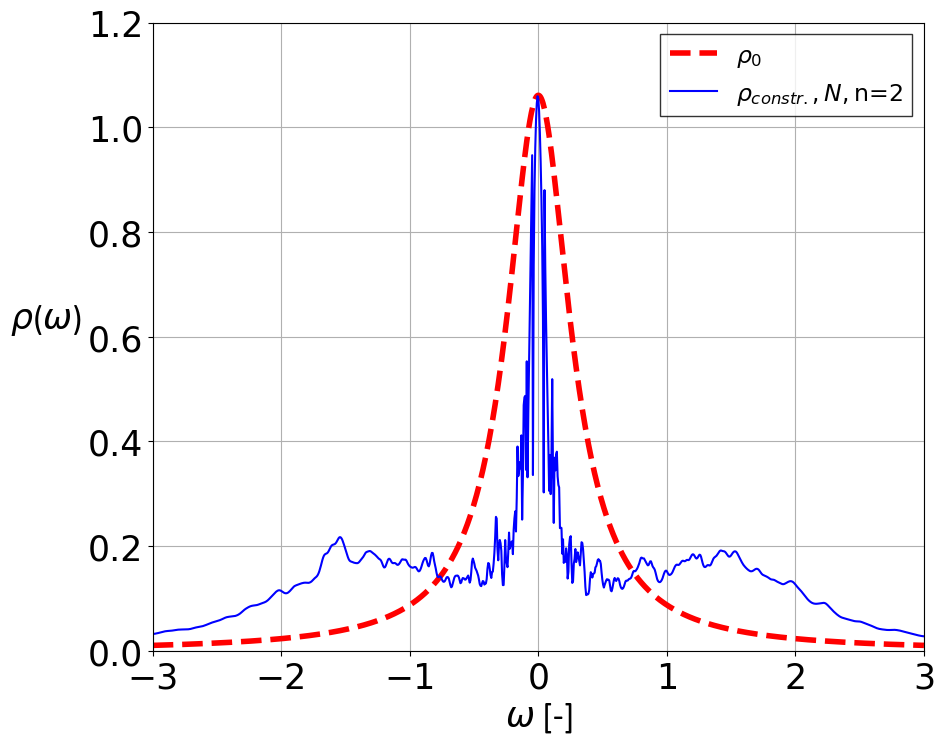

In [21]:
poles,Nit=2,2000
test=DEDlib(poles=poles,Nit=Nit)
name,labels='constraintN4p','$\\rho_{constr.},N,$n=2'
plot=test.DOSplot(name,labels)

In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.auto import trange
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy
from numba import njit

#class DED:

def Jordan_wigner_transform(j,lattice_length):
    """Jordan_wigner_transform(j, lattice_length). 
Defines the Jordan Wigner transformation for a 1D lattice."""
    operators=sigmaz()
    for _ in range(j-1): operators=tensor(operators,sigmaz())
    if j == 0: operators=sigmam()
    else: operators=tensor(operators,sigmam())
    for _ in range(lattice_length - j - 1): operators=tensor(operators,identity(2))
    return operators

@njit
def Lorentzian(omega,Gamma,poles,Ed=-3/2,Sigma=3/2):
    """Lorentzian(omega, Gamma, poles,Ed=-3/2,Sigma=3/2). 
Defines the non-interacting DOS (rho0) and selects random sites based on the number of sites in the 1D lattice model and the calculated distribution."""
    return -np.imag(1/(omega-Ed-Sigma+1j*Gamma))/np.pi,np.array([Gamma*np.tan(np.pi*(pi-1/2))+Ed+Sigma for pi in np.random.uniform(0,1,poles)])

@njit
def Startrans(poles,select,omega,eta,row=0):
    """Startrans(poles,select,row,omega, eta). 
Function to transform 1D lattice matrices in order to calculates parameters impengergy, bathenergy and Vkk from random sampling distribution."""
    Pbath,Dbath,pbar,G=np.zeros((poles,poles)),np.zeros((poles,poles)),np.zeros((poles,poles)),np.zeros(omega.shape,dtype='complex_')
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i: Pbath[i+1][j+1]=-1/np.sqrt((poles-i-1)*(poles-i))
        Pbath[i+1][i]=np.sqrt(poles-i-1)/np.sqrt(poles-i)
    Pbath[row,:]=1/np.sqrt(poles)
    for i, _ in enumerate(select): Dbath[i][i]=select[i]
    pbar[1:,1:]=np.linalg.eig((Pbath@Dbath@Pbath.T)[1:,1:])[1]
    pbar[row][row]=1
    for i, _ in enumerate(select): G+=1/len(select)/(omega-select[i]+1.j*eta)
    return pbar.T@Pbath@Dbath@Pbath.T@pbar,G,select

def Operators(c,Nimpurities,poles):
    posimp=[int(2*poles/Nimpurities*i) for i in range(Nimpurities)]
    impn=[sum([c[posimp[k]+i].dag()*c[posimp[k]+i] for i in range(2)]) for k in range(Nimpurities)]
    bathn=[[sum([c[2*j+i+2+posimp[k]].dag()*c[2*j+i+2+posimp[k]] for i in range(2)]) for j in range(int(poles/Nimpurities)-1)] for k in range(Nimpurities)]
    crossn=[[sum([c[posimp[k]+i].dag()*c[2*j+i+2+posimp[k]]+c[2*j+i+2+posimp[k]].dag()*c[posimp[k]+i] for i in range(2)]) for j in range(int(poles/Nimpurities)-1)] for k in range(Nimpurities)]
    Un=sum([c[posimp[k]].dag()*c[posimp[k]]*c[posimp[k]+1].dag()*c[posimp[k]+1] for k in range(Nimpurities)])
    Sigman=sum([c[posimp[k]].dag()*c[posimp[k]]+c[posimp[k]+1].dag()*c[posimp[k]+1] for k in range(Nimpurities)])
    U2n=sum([c[posimp[k]+i].dag()*c[posimp[k]+i]*c[posimp[l]+j].dag()*c[posimp[l]+j] for i in range(2) for j in range(2) for l in range(Nimpurities) for k in range(Nimpurities) if k !=l])
    Jn=sum([1/2*(c[posimp[k]].dag()*c[posimp[k]+1]*c[posimp[l]+1].dag()*c[posimp[l]]+c[posimp[k]+1].dag()*c[posimp[k]]*c[posimp[l]].dag()*c[posimp[l]+1])
                    +1/4*(c[posimp[k]].dag()*c[posimp[k]]-c[posimp[k]+1].dag()*c[posimp[k]+1])*(c[posimp[l]].dag()*c[posimp[l]]-c[posimp[l]+1].dag()*c[posimp[l]+1]) for l in range(Nimpurities) for k in range(Nimpurities) if k!=l])
    n=[sum([c[j+posimp[i]].dag()*c[j+posimp[i]] for j in range(2*int(poles/Nimpurities))]) for i in range(Nimpurities)]
    return (impn,bathn,crossn,Un,Sigman,U2n,Jn),n

def HamiltonianAIM(impenergy,bathenergy,Vkk,U,Sigma,U2,J,Hn,H0=0):
    """HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma). 
Based on energy parameters calculates the Hamiltonian of a single-impurity system."""
    for k in range(len(impenergy)):
        H0+=impenergy[k]*Hn[0][k]
        for j in range(len(bathenergy[k])): H0+=bathenergy[k][j]*Hn[1][k][j]+Vkk[k][j]*Hn[2][k][j]
    return H0,H0+U*Hn[3]-Sigma*Hn[4]+(U2/2-J/4)*Hn[5]-J*Hn[6]

@njit
def MBGT0(omega,eta,evals,exp,exp2):
    G=np.zeros(len(omega),dtype='complex_')
    for i,expi in enumerate(exp): G+=abs(expi)**2/(omega+evals[i+1]-evals[0]+1.j*eta)+abs(exp2[i])**2/(omega+evals[0]-evals[i+1]+1.j*eta)
    return G

@njit
def MBGTnonzero(omega,eta,evals,exp,exp2,eevals):
    G=np.zeros(len(omega),dtype='complex_')
    for i,evi in enumerate(evals):
        for j,evj in enumerate(evals):
            G+=(exp[i][j]*exp2[j][i]/(omega+evi-evj+1.j*eta)+exp[j][i]*exp2[i][j]/(omega+evj-evi+1.j*eta))*eevals[i]
    return G

def MBGAIM(omega,H,c,eta,Tk,Boltzmann,evals=[],evecs=[],etaoffset=1e-4,posoffset=np.zeros(1,dtype='int')):
    """MBGAIM(omega, H, c, eta). 
Calculates the many body Green's function based on the Hamiltonian eigenenergies/-states."""
    if ~np.any(evals): evals,evecs=scipy.linalg.eigh(H.data.toarray())
    if Tk==[0]:
        vecn=np.conj(evecs[:,1:]).T
        exp,exp2=vecn@c[0].data.tocoo()@evecs[:,0],vecn@c[0].dag().data.tocoo()@evecs[:,0]
        return MBGT0(omega,eta,evals,exp,exp2),Boltzmann,evecs[:,0]
    else:
        MGdat,eta[int(np.round(len(eta)/2))+posoffset]=np.ones((len(Tk),len(omega)),dtype='complex_'),etaoffset
        for k,T in enumerate(Tk):
            if Boltzmann[k]!=0:
                eevals,vecn=np.exp(-evals/T-scipy.special.logsumexp(-evals/T)),np.conj(evecs).T
                exp,exp2=vecn@c[0].data.tocoo()@evecs,vecn@c[0].dag().data.tocoo()@evecs
                MGdat[k,:]=MBGTnonzero(omega,eta,evals,exp,exp2,eevals)
        return MGdat.squeeze(),Boltzmann,evecs[:,0]

def Constraint(ctype,H0,H,omega,eta,c,n,Tk,Nfin):
    """Constraint(ctype,H0,H,omega,eta,c,n). 
Constraint implementation function for DED method with various possible constraints."""
    if ctype[0]=='m':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data),k=1,which='SA')[1][:,0],
                                        scipy.sparse.linalg.eigsh(np.real(H.data),k=1,which='SA')[1][:,0])))
        exp=np.conj(vecs)@n[0].data@vecs.T
        if ctype=='mosn' and np.round(exp[0,0])==np.round(exp[1,1]):
            return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        else:
            return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
    elif ctype[0]=='s':
        vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0,0])[1][:,0]
        evals,evecs=scipy.linalg.eigh(H.data.toarray())
        if ctype=='ssn':
            Boltzmann=np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n[0].data@evecs),np.conj(vecs)@n[0].data@vecs.T)]-evals[0])/Tk)*Nfin.astype('int')
            return MBGAIM(omega,H,c,eta,Tk,Boltzmann,evals,evecs,4e-4,np.array([-2,-1,0,1,2])),True
        else:
            return MBGAIM(omega,H,c,eta,Tk,np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n[0].data@evecs),np.conj(vecs)@n[0].data@vecs.T)]-evals[0])/Tk),evals,evecs,4e-4,np.array([-2,-1,0,1,2])),True
    elif ctype[0]=='n':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data),k=1,which='SA')[1][:,0],
                                                scipy.sparse.linalg.eigsh(np.real(H.data),k=1,which='SA')[1][:,0])))
        exp=[np.conj(vecs)@ni.data@vecs.T for ni in n]
        if ctype=='n%2' and all([int(np.round(expi[0,0]))%2==int(np.round(expi[1,1]))%2 for expi in exp]):
            return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        elif ctype=='n' and all([np.round(expi[0,0])==np.round(expi[1,1]) for expi in exp]):
            return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        else:
            return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
    elif ctype[0]=='d':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.linalg.eigh(H.data.toarray(),eigvals=[0,0])[1][:,0],
                                                scipy.linalg.eigh(H0.data.toarray(),eigvals=[0,0])[1][:,0])))
        exp=[np.conj(vecs)@ni.data@vecs.T for ni in n]
        if ctype=='dn' and all([np.round(expi[0,0])==np.round(expi[1,1]) for expi in exp]):
            return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        else:
            return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
    else:
        return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
    
def find_nearest(array,value):
    for i in (i for i,arrval in enumerate(array) if np.isclose(arrval,value,atol=0.1)): return i

def main(N=200000,poles=4,U=3,Sigma=3/2,Ed=-3/2,Gamma=0.3,SizeO=1001,etaco=[0.02,1e-39],ctype='n',Edcalc='',bound=3,Tk=[0],Nimpurities=1,U2=0,J=0,posb=1,log=False,base=1.5):
    """main(N=1000000,poles=4,U=3,Sigma=3/2,Gamma=0.3,SizeO=1001,etaco=[0.02,1e-39], ctype='n',Ed='AS'). 
The main DED function simulating the Anderson impurity model for given parameters."""
    if log: omega,selectpcT,selectpT,Npoles=np.concatenate((-np.logspace(np.log(bound)/np.log(base),-40,int(np.round(SizeO/2)),base=base),np.logspace(-40,np.log(bound)/np.log(base),int(np.round(SizeO/2)),base=base))),[],[],int(poles/Nimpurities)
    else: omega,selectpcT,selectpT,Npoles=np.linspace(-bound,bound,SizeO),[],[],int(poles/Nimpurities)
    c,pbar,eta=[Jordan_wigner_transform(i,2*poles) for i in range(2*poles)],trange(N,position=posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'),etaco[0]*abs(omega)+etaco[1]
    (Hn,n),AvgSigmadat,Nfin,nd=Operators(c,Nimpurities,poles),np.zeros((len(Tk),SizeO),dtype='complex_'),np.zeros(len(Tk),dtype='float'),np.zeros(len(Tk),dtype='complex_')
    while pbar.n<N:
        reset=False
        while not reset:
            NewM,nonG,select=Startrans(Npoles,np.sort(Lorentzian(omega,Gamma,Npoles,Ed,Sigma)[1]),omega,eta)
            H0,H=HamiltonianAIM(np.repeat(NewM[0][0],Nimpurities),np.tile([NewM[k+1][k+1] for k in range(len(NewM)-1)],(Nimpurities,1)),np.tile(NewM[0,1:],(Nimpurities,1)),U,Sigma,U2,J,Hn)
            try: (MBGdat,Boltzmann,Ev0),reset=Constraint(ctype,H0,H,omega,eta,c,n,Tk,np.array([ar<N for ar in Nfin]))
            except (np.linalg.LinAlgError,ValueError,scipy.sparse.linalg.ArpackNoConvergence): (MBGdat,Boltzmann,Ev0),reset=(np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
            if np.isnan(1/nonG-1/MBGdat+Sigma).any() or np.array([i>=1000 for i in np.real(1/nonG-1/MBGdat+Sigma)]).any(): reset=False
            selectpT.append(select)
        Nfin,AvgSigmadat,nd=Nfin+Boltzmann,AvgSigmadat+(1/nonG-1/MBGdat+Sigma)*Boltzmann[:,None],nd+np.conj(Ev0).T@sum(Hn[0]).data.tocoo()@Ev0*Boltzmann
        selectpcT.append(select)
        if ctype=='sn': pbar.n+=1
        else: pbar.n=int(min(Nfin))
        pbar.refresh()
    pbar.close()
    if Edcalc == 'AS': return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(omega-AvgSigmadat/Nfin[:,None]+(AvgSigmadat[:,int(np.round(SizeO/2))]/Nfin)[:,None]+1j*Gamma)))/np.pi).squeeze(),Lorentzian(omega,Gamma,poles)[0],omega,selectpT,selectpcT,pbar.format_dict["elapsed"]
    else: return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(omega-AvgSigmadat/Nfin[:,None]-Ed+1j*Gamma)))/np.pi).squeeze(),Lorentzian(omega,Gamma,poles,Ed,Sigma)[0],omega,selectpT,selectpcT,pbar.format_dict["elapsed"]

def DOSplot(fDOS,Lor,omega,name,labels,log=False,ymax=1.2,save=True):
    """DOSplot(fDOS,Lor,omega,name,labels). 
A plot function to present results from the AIM moddeling for a single results with a comparison to the non-interacting DOS."""
    plt.figure(figsize=(10,8))
    plt.rc('legend',fontsize=17)
    plt.rc('font',size=25)
    plt.rc('xtick',labelsize=25)
    plt.rc('ytick',labelsize=25)
    axis_font={'fontname':'Calibri','size':'25'}
    plt.xlim(min(omega),max(omega))
    if not log:
        plt.gca().set_ylim(bottom=0,top=ymax)
        plt.gca().set_xticks(np.linspace(min(omega),max(omega),2*int(max(omega))+1),minor=False)
    else: 
        plt.yscale('log')
        plt.gca().set_ylim(bottom=0.0001,top=10)
        plt.gca().set_xticks([-8,-6,-4,-2,0,2,4,6,8],minor=False)
    plt.xlabel("$\\omega$ [-]",**axis_font)
    plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom",rotation=0,labelpad=30,**axis_font)
    plt.plot(omega,Lor,'--r',linewidth=4,label='$\\rho_0$')
    plt.plot(omega,fDOS,'-b',label=labels)
    plt.legend(fancybox=False).get_frame().set_edgecolor('black')
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(name+'.png',format='png')
        plt.savefig(name+'.svg',format='svg',dpi=3600)
    plt.draw()
    plt.pause(5)
    plt.close()
    return plt

Iterations:   0%|          | 0/200000 [00:00<?, ?it/s]

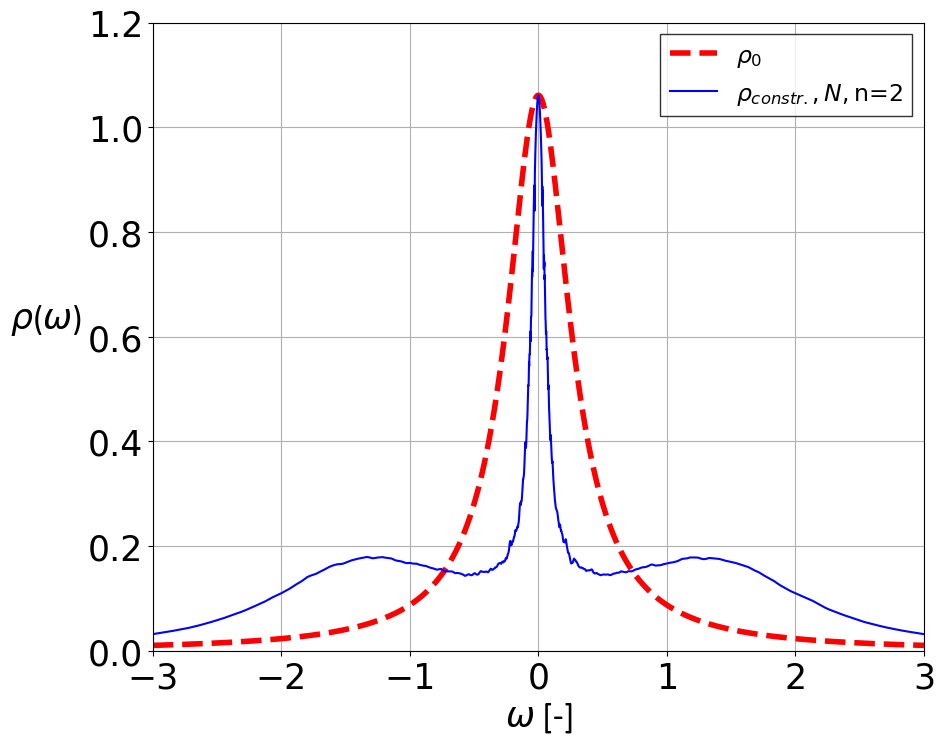

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [2]:
nd,_,fDOS,Lor,omega,selectpT,selectpcT,tsim=main(**{"N":200000,"poles":2,"Ed":-3/2,"SizeO":20000,"ctype":'n',"log":True})
DOSplot(fDOS,Lor,omega,'constraintN2p','$\\rho_{constr.},N,$n=2',save=False)

In [21]:
fDOS[9940:10100]

array([1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 ,
       1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 ,
       1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 ,
       1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 ,
       1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 ,
       1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 ,
       1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 ,
       1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 ,
       1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 ,
       1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 ,
       1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 ,
       1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 , 1.0610314 ,
       1.06103141, 1.06103141, 1.06103141, 1.06103141, 1.06103141,
       1.06103141, 1.06103141, 1.06103141, 1.06103141, 1.06103141,
       1.06103141, 1.06103141, 1.06103141, 1.06103141, 1.06103

In [19]:
omega[9990:10100]

array([-9.18584280e-08, -9.16994766e-08, -9.15408002e-08, -9.13823984e-08,
       -9.12242706e-08, -9.10664165e-08, -9.09088355e-08, -9.07515273e-08,
       -9.05944912e-08, -9.04377268e-08,  9.04377268e-08,  9.05944912e-08,
        9.07515273e-08,  9.09088355e-08,  9.10664165e-08,  9.12242706e-08,
        9.13823984e-08,  9.15408002e-08,  9.16994766e-08,  9.18584280e-08,
        9.20176550e-08,  9.21771580e-08,  9.23369375e-08,  9.24969939e-08,
        9.26573278e-08,  9.28179396e-08,  9.29788298e-08,  9.31399988e-08,
        9.33014473e-08,  9.34631756e-08,  9.36251842e-08,  9.37874737e-08,
        9.39500445e-08,  9.41128971e-08,  9.42760319e-08,  9.44394496e-08,
        9.46031505e-08,  9.47671352e-08,  9.49314041e-08,  9.50959577e-08,
        9.52607966e-08,  9.54259213e-08,  9.55913321e-08,  9.57570297e-08,
        9.59230145e-08,  9.60892870e-08,  9.62558478e-08,  9.64226972e-08,
        9.65898359e-08,  9.67572643e-08,  9.69249829e-08,  9.70929922e-08,
        9.72612927e-08,  

In [123]:
def Jordan_wigner_transform(j,lattice_length):
    """Jordan_wigner_transform(j, lattice_length). 
Defines the Jordan Wigner transformation for a 1D lattice."""
    operators=sigmaz()
    for _ in range(j-1): operators=tensor(operators,sigmaz())
    if j == 0: operators=sigmam()
    else: operators=tensor(operators,sigmam())
    for _ in range(lattice_length - j - 1): operators=tensor(operators,identity(2))
    return operators

poles=1

f=[Jordan_wigner_transform(i,2*poles) for i in range(2*poles)]

In [142]:
sigmap()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]

In [144]:
f[1].dag()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0.  0.  0.]]

In [138]:
f

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 0.  0.  0.  0.]
  [ 1.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0. -1.  0.]]]

In [151]:
c2=Qobj([[0,0,0,0],[1,0,0,0],[0,0,0,0],[0,0,1,0]])

In [150]:
c1=Qobj([[0,0,0,0],[0,0,0,0],[1,0,0,0],[0,-1,0,0]])

In [162]:
c1=tensor(sigmam(),sigmaz())
c2=tensor(identity(2),sigmam())
c1*c1.dag()+c2*c2.dag()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 2.]]

In [157]:
c12=tensor(sigmaz(),sigmam())
c22=tensor(sigmam(),identity(2))

In [158]:
c12*c12.dag()+c22*c22.dag()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 2.]]

In [161]:
c13=tensor(identity(2),sigmam())
c23=tensor(sigmam(),sigmaz())
c13.dag()*c13+c23.dag()*c23

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

In [146]:
f[1].dag()*f[1]+f[0].dag()*f[0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

In [115]:
poles=2
f=[Jordan_wigner_transform(i,2*poles) for i in range(2*poles)]

In [98]:
from scipy.sparse import csc_matrix
x=csc_matrix(f[0].data.tocoo())

In [130]:
f[0].dag()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [133]:
print(tensor(f[0],f[0].dag()))

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [132]:
f[1].dag()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0.  0.  0.]]

In [134]:
print(tensor(f[1],f[1].dag()))

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 

In [125]:
f[1]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0. -1.  0.]]

In [121]:
print(tensor(f[0].dag(),f[1]).data.tocoo())

  (1, 8)	(1+0j)
  (3, 10)	(-1+0j)
  (5, 12)	(1+0j)
  (7, 14)	(-1+0j)


In [122]:
print(tensor(f[1].dag(),f[0]).data.tocoo())

  (2, 4)	(1+0j)
  (3, 5)	(1+0j)
  (10, 12)	(-1+0j)
  (11, 13)	(-1+0j)


In [114]:
print(tensor(f[1].dag(),identity(4)).data.tocoo())

  (0, 4)	(1+0j)
  (1, 5)	(1+0j)
  (2, 6)	(1+0j)
  (3, 7)	(1+0j)
  (8, 12)	(-1+0j)
  (9, 13)	(-1+0j)
  (10, 14)	(-1+0j)
  (11, 15)	(-1+0j)


In [118]:
print(f[3].dag().data.tocoo())

  (0, 1)	(1-0j)
  (2, 3)	(-1-0j)
  (4, 5)	(-1-0j)
  (6, 7)	(1-0j)
  (8, 9)	(-1-0j)
  (10, 11)	(1-0j)
  (12, 13)	(1-0j)
  (14, 15)	(-1-0j)


In [119]:
print(f[2].dag().data.tocoo())

  (0, 2)	(1-0j)
  (1, 3)	(1-0j)
  (4, 6)	(-1-0j)
  (5, 7)	(-1-0j)
  (8, 10)	(-1-0j)
  (9, 11)	(-1-0j)
  (12, 14)	(1-0j)
  (13, 15)	(1-0j)


In [116]:
print(f[1].dag().data.tocoo())

  (0, 4)	(1-0j)
  (1, 5)	(1-0j)
  (2, 6)	(1-0j)
  (3, 7)	(1-0j)
  (8, 12)	(-1-0j)
  (9, 13)	(-1-0j)
  (10, 14)	(-1-0j)
  (11, 15)	(-1-0j)


In [117]:
print(f[0].dag().data.tocoo())

  (0, 8)	(1-0j)
  (1, 9)	(1-0j)
  (2, 10)	(1-0j)
  (3, 11)	(1-0j)
  (4, 12)	(1-0j)
  (5, 13)	(1-0j)
  (6, 14)	(1-0j)
  (7, 15)	(1-0j)


In [86]:
f[0],f[1]

(Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 0.  0.  0.  0.]
  [ 1.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0. -1.  0.]])

In [41]:
c[0].data.toarray()

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])

In [55]:
tensor(sigmam(),identity(2))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]

In [46]:
c[0][3,1]

(1+0j)

In [108]:
c[0].dag(),c[1].dag()

(Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[0. 0. 1. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 0.  1.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0. -1.]
  [ 0.  0.  0.  0.]])

In [66]:
ddagu=tensor(f[0].dag(),f[1].dag())
ddagd=tensor(f[1].dag(),f[0].dag())

In [4]:
Gamma=0.3
H=(ddagu+ddagd)*Gamma
H=H+H.dag()
Hgfin=H.data.toarray()

In [5]:
Qobj(Hgfin)

Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[ 0.   0.   0.   0.   0.   0.   0.3  0.   0.   0.3  0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.3  0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.3  0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.3
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.3  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  -0.3]
 [ 0.   0.3  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  -0.3  0. ]
 [ 0.3  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  -0.3]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

In [6]:
dof=f[0].shape[0]
Ed=-3/2
U=3

for i in range(dof):
    Hgfin[i*dof+1,i*dof+1]=Ed
    Hgfin[i*dof+2,i*dof+2]=Ed
    Hgfin[i*dof+3,i*dof+3]=2*Ed+U
Qobj(Hgfin)

Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[ 0.   0.   0.   0.   0.   0.   0.3  0.   0.   0.3  0.   0.   0.   0.
   0.   0. ]
 [ 0.  -1.5  0.   0.   0.   0.   0.   0.3  0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.  -1.5  0.   0.   0.   0.   0.   0.   0.   0.  -0.3  0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.3
   0.   0. ]
 [ 0.   0.   0.   0.   0.  -1.5  0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.3  0.   0.   0.   0.   0.  -1.5  0.   0.   0.   0.   0.   0.   0.
   0.  -0.3]
 [ 0.   0.3  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  -0.3  0. ]
 [ 0.3  0.   0.   0.   0.   0.   0.   0.   0.  -1.5  0.   0.   0.   0.
   0.  -0.3]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -1.5  0.   0.

In [67]:
fdagu=tensor(f[0].dag(),identity(4)).data.toarray()
fdagd=tensor(f[1].dag(),identity(4)).data.toarray()

In [53]:
fdagu

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.

In [59]:
Q=-1.j*sigmay()
Sz=sigmaz()

In [54]:
Sz,Qz=np.array([0, 1, -1, 0]),np.array([-1, 0, 0, 1])
Kodep=(Sz+50)*100+(Qz+50)

In [55]:
dSz,dQz=np.array([0, 1, -1, 0]),np.array([-1, 0, 0, 1])

def delta_enkode(dSz,dQz):
    return dSz*100 + dQz


Kode=np.array([])
for i in range(dof):
    Kode=np.append(Kode,Kodep + delta_enkode(dSz[i],dQz[i])).flatten() 

In [10]:
Kodep,Kode

(array([5049, 5150, 4950, 5051]),
 array([5048., 5149., 4949., 5050., 5149., 5250., 5050., 5151., 4949.,
        5050., 4850., 4951., 5050., 5151., 4951., 5052.]))

In [56]:
L=dof
newL=dof*L

In [12]:
Kode[:newL]

array([5048., 5149., 4949., 5050., 5149., 5250., 5050., 5151., 4949.,
       5050., 4850., 4951., 5050., 5151., 4951., 5052.])

In [13]:
Kode

array([5048., 5149., 4949., 5050., 5149., 5250., 5050., 5151., 4949.,
       5050., 4850., 4951., 5050., 5151., 4951., 5052.])

In [14]:
Kodep

array([5049, 5150, 4950, 5051])

In [57]:
xK=np.unique(Kode[:newL])
nK=xK.shape[0]
iK=0
E=np.zeros(newL)
c=np.zeros((newL,newL))
Hk=np.zeros((newL,newL))
Kodep=np.append(Kodep,np.zeros(newL-L))

for blk in range(nK):
    b=np.argwhere(Kode[:newL] == xK[blk])
    LK=b.shape[0]

    for i in range(LK):
        for j in range(LK):
            Hk[i,j]=Hgfin[b[i,0],b[j,0]]

    EK,cK=scipy.linalg.eigh(Hk[:LK,:LK])

    for i in range(LK):
        for j in range(LK):
            c[b[i,0],b[j,0]]=cK[i,j]
        E[b[i,0]]=EK[i]
        Kodep[b[i,0]]=xK[blk]
    iK+=LK

Lambda = 3.0

E*=Lambda**(-0.5)

In [16]:
E

array([ 0.       , -0.8660254, -0.8660254, -0.8660254,  0.       ,
       -0.8660254, -0.8660254, -0.8660254,  0.       ,  0.       ,
       -0.8660254, -0.8660254,  0.       ,  0.       ,  0.       ,
        0.       ])

In [17]:
E,c,Kodep,newL

(array([ 0.       , -0.8660254, -0.8660254, -0.8660254,  0.       ,
        -0.8660254, -0.8660254, -0.8660254,  0.       ,  0.       ,
        -0.8660254, -0.8660254,  0.       ,  0.       ,  0.       ,
         0.       ]),
 array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0., -1.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
       

In [58]:
def Esort(E0,c0,Kodep0,L):
    ix=np.argsort(E0)
    Es=E0[ix]
    cs=np.zeros((L,L))
    Ks=np.zeros(L)
    for i in range(L):
        cs[:,i]=c0[:,ix[i]]
        Ks[i]=Kodep0[ix[i]]
    return (Es,cs,Ks)

(E,c,Kodep) = Esort(E,c,Kodep,newL)

In [59]:
E,newL

(array([-0.8660254, -0.8660254, -0.8660254, -0.8660254, -0.8660254,
        -0.8660254, -0.8660254, -0.8660254,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ]),
 16)

In [60]:
def Impose(E0,L,SMALL):
    E1=E0
    i=0
    while i<L:
        j=i+1
        while j<L and abs(E0[j]-E0[i])<SMALL:
            j+=1
        E1[i:j]=np.mean(E0[i:j])
        i=j
    return E1

KEPT=800
K=newL
IMPOSE = True
SMALL = 1e-6
if newL>KEPT:
    newL=KEPT
if IMPOSE:
    E=Impose(E,newL,SMALL)

E=E-E[0]

In [61]:
E

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.8660254, 0.8660254, 0.8660254, 0.8660254,
       0.8660254, 0.8660254, 0.8660254, 0.8660254])

In [23]:
newL

16

In [31]:
fdagu.dag()
c[:K,:newL].conj().T

array([[ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,
         0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0., -0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0

In [49]:
fdagd

array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0

In [48]:
c[:K,:newL].conj().T*c[:K,:newL]

array([[ 0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [-0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,
        -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0., -0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0

In [69]:
#fdagu=c[:K,:newL].conj().T*fdagu*c[:K,:newL]
#fdagd=c[:K,:newL].conj().T*fdagd*c[:K,:newL]
fdagu=c[:K,:newL].conj().T@fdagu@c[:K,:newL]
fdagd=c[:K,:newL].conj().T@fdagd@c[:K,:newL]

In [71]:
np.remainder(23,5)

3

In [74]:
Sz,Qz=np.array([0, 1, -1, 0]),np.array([-1, 0, 0, 1])
#Kodep=(Sz+50)*100+(Qz+50)

In [75]:
kode=enkode(Sz,Qz)
kode

array([5049, 5150, 4950, 5051])

In [76]:
dekode(kode)

(array([ 0.,  1., -1.,  0.]), array([-1,  0,  0,  1], dtype=int32))

In [73]:
def enkode(Sz,Qz):
    kode=(Sz+50)*100+(Qz+50)
    return kode

def dekode(kode):
    Qz=np.remainder(kode,100)-50
    Sz=(kode-np.remainder(kode,100))/100-50
    return (Sz,Qz)

In [80]:
Sz=np.append(Sz,np.zeros(newL-L))
Qz=np.append(Qz,np.zeros(newL-L))
print(Sz)
(Sz[:newL],Qz[:newL]) = dekode(Kodep[:newL])

In [81]:
Sz,Qz

(array([ 1., -1.,  0.,  2.,  0.,  1., -2., -1.,  0.,  1., -1.,  0.,  0.,
         1., -1.,  0.]),
 array([-1., -1.,  0.,  0.,  0.,  1.,  0.,  1., -2., -1., -1.,  0.,  0.,
         1.,  1.,  2.]))

In [61]:
tensor(c[0],c[1].dag())

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 

In [40]:
Qobj(H)

Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

In [39]:
dof=4
H=np.zeros((c[0].shape[0]*dof,c[0].shape[0]*dof))
H[1,1]=1
H

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [1]:
import DEDlib
import numpy as np

dir="C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block1 Sym AIM\\Final version\\"
files=["constraintN2p","constraintN3p","constraintN4p","constraintN5p","constraintN6p"]
DOST=np.zeros((len(files),1001),dtype='float')

for i,file in enumerate(files):
    [omega,DOST[i]]=DEDlib.textfileR(dir+file)


In [2]:
DOST

array([[0.03247875, 0.03267814, 0.03287617, ..., 0.03261882, 0.03240667,
        0.03220177],
       [0.0327093 , 0.03291973, 0.03313169, ..., 0.03323254, 0.03299014,
        0.0327501 ],
       [0.03242014, 0.03264898, 0.0328835 , ..., 0.03313055, 0.03290381,
        0.03267755],
       [0.03264007, 0.03286233, 0.03308582, ..., 0.03295775, 0.03272982,
        0.0325049 ],
       [0.03286796, 0.0331073 , 0.03334566, ..., 0.03263962, 0.03238996,
        0.03214457]])

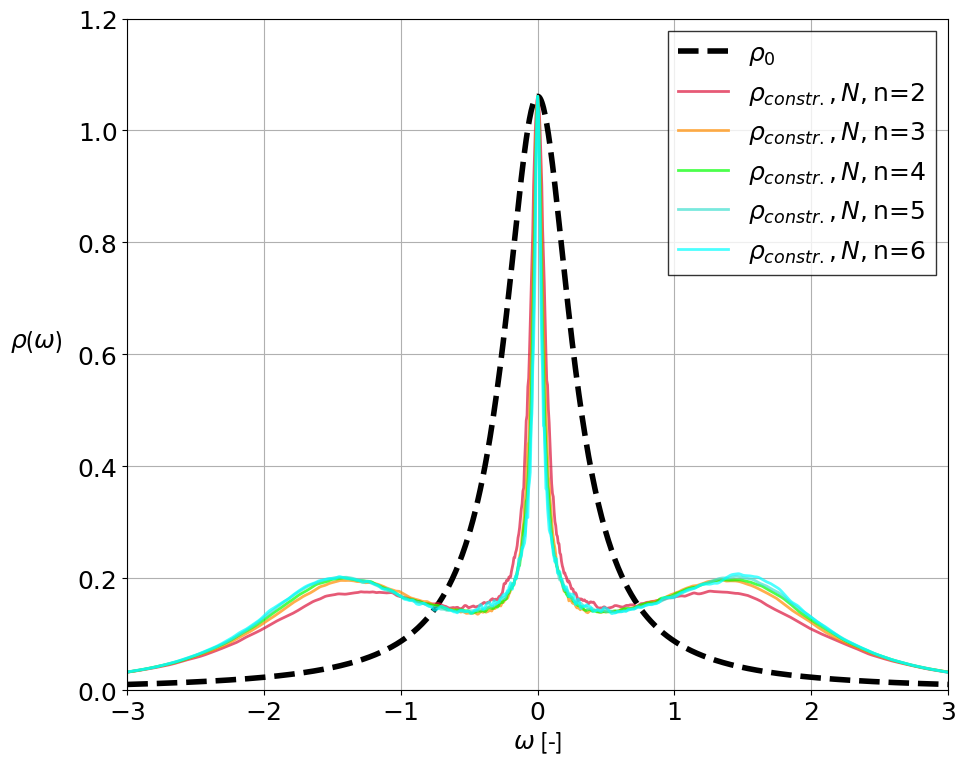

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [5]:
labelnames=['$\\rho_{constr.},N,$n=2','$\\rho_{constr.},N,$n=3','$\\rho_{constr.},N,$n=4','$\\rho_{constr.},N,$n=5','$\\rho_{constr.},N,$n=6']
DEDlib.DOSmultiplot(omega,np.tile(omega,(len(files),1)),DOST,np.tile(len(omega),len(files)),labelnames,'polestotal',DEDlib.Lorentzian(omega,0.3,4,-3/2,3/2)[0])